# **LAB SESSION 2 - Bagging and Random Forests**

## Utils

*Note: in all this project, use **the value 0** when you need to choose a value for a random state*

In [6]:
import numpy as np
import pandas as pd # data analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

## Ex 1: comparison between random forests and bagging

We work with the [Urban Land Cover data base](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover). The data are used for automated mapping of urban land cover (trees, grass, soil, concrete, asphalt, buildings, etc.) in satellite or aerial imagery. Nine types of urban land cover are considered and multi-scale spectral, size, shape, and texture information are used for classification. The data consists in a train set and a test set. **The goal is to predict the urban land cover (the variable named `class`) based on the multi-scale spectral, size, shape, and texture information. It is then a classification problem. We will use the overall accuracy (1-misclassification rate) as performance criterion**. Note that other preformnce criterion exist for classification problem such as specificity, sensitivity, F-score, etc.

Before to start, we: 
 1) load the data and perform a briel descriptive analysis of them;
 2) select the variables that we will use in the exercise, 


In [9]:
# Load the data 
ulc_train = pd.read_csv("ULC_training.csv") 
ulc_test = pd.read_csv("ULC_testing.csv") 

In [28]:
# Display the dimension
print(ulc_train.shape)
print(ulc_test.shape)

(168, 148)
(507, 148)


In [29]:
# Have a first quick look at the datasets and display the dimension
ulc_train.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


In [30]:
ulc_test.head()

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,31.15,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,12.01,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,18.75,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,27.67,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,32.05,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76


In [31]:
## Display a statistic summary for the numerical variables
ulc_train.describe(include='all') #unique, top, freq, apears nan for continuous variables

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,168,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,...,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.008512,565.869048,1.132976,165.569821,2.077679,2.229881,161.577083,163.672440,171.459226,...,23.769881,3.098274,0.796488,0.665000,7.795536,1.594405,0.615357,0.014583,983.309524,1275.292917
std,NaN,0.634807,679.852886,0.489150,61.883993,0.699600,0.703572,63.407201,71.306748,67.973969,...,12.836522,6.101883,0.103930,0.179086,0.670491,0.460627,0.239900,0.153677,880.013745,603.658611
min,NaN,1.000000,10.000000,0.020000,37.670000,1.000000,1.060000,30.680000,32.210000,40.120000,...,4.020000,1.000000,0.330000,0.240000,6.290000,0.230000,0.070000,-0.360000,56.000000,336.730000
25%,NaN,1.537500,178.000000,0.787500,133.977500,1.547500,1.700000,91.040000,101.187500,120.165000,...,13.965000,1.395000,0.757500,0.560000,7.357500,1.325000,0.460000,-0.080000,320.000000,817.405000
50%,NaN,1.920000,315.000000,1.085000,164.485000,1.940000,2.130000,187.560000,160.615000,178.345000,...,21.135000,1.740000,0.810000,0.690000,7.790000,1.660000,0.620000,-0.040000,776.000000,1187.025000
75%,NaN,2.375000,667.000000,1.410000,221.895000,2.460000,2.680000,210.940000,234.815000,236.002500,...,29.957500,2.285000,0.870000,0.810000,8.260000,1.945000,0.810000,0.120000,1412.500000,1588.427500


In [32]:
ulc_test.describe(include='all')

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
count,507,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,...,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000,507.000000
unique,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,building,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.025720,562.504931,1.237574,165.612939,2.187081,2.277318,166.290355,162.291953,168.256667,...,24.601144,2.931657,0.817712,0.597732,8.048698,1.455838,0.653905,0.027436,1398.706114,1101.998185
std,NaN,0.619254,698.655240,0.561988,63.230806,0.874054,0.718441,59.217648,73.455101,69.702475,...,12.203441,4.942887,0.106007,0.197505,0.787912,0.451781,0.251287,0.133834,1097.323462,533.927869
min,NaN,1.000000,22.000000,0.000000,26.850000,1.000000,1.040000,22.910000,26.520000,31.110000,...,2.650000,1.000000,0.200000,0.100000,5.690000,0.240000,0.030000,-0.360000,34.000000,211.270000
25%,NaN,1.580000,159.000000,0.840000,127.485000,1.650000,1.715000,146.460000,97.585000,111.715000,...,14.485000,1.375000,0.770000,0.455000,7.370000,1.160000,0.470000,-0.080000,601.000000,726.745000
50%,NaN,1.950000,323.000000,1.210000,170.650000,2.000000,2.180000,189.630000,158.280000,167.750000,...,22.380000,1.920000,0.840000,0.610000,8.020000,1.440000,0.710000,-0.020000,1148.000000,1011.230000
75%,NaN,2.380000,681.500000,1.565000,224.825000,2.490000,2.675000,206.780000,237.375000,238.480000,...,33.825000,2.800000,0.890000,0.760000,8.750000,1.775000,0.860000,0.145000,1874.000000,1335.640000


In [33]:
## Display the distribution of the target variable in the two datasets
ulc_train['class'].value_counts()


class
grass        29
building     25
concrete     23
tree         17
shadow       16
car          15
pool         15
asphalt      14
soil         14
Name: count, dtype: int64

In [34]:
ulc_test['class'].value_counts()

class
building     97
concrete     93
tree         89
grass        83
shadow       45
asphalt      45
car          21
soil         20
pool         14
Name: count, dtype: int64

In [11]:
# Select the variables that we be used 
target_column = "class" # The response variable that we will consider
features_columns = list(ulc_train)
features_columns.remove('class') # The predictors/features used to predict the target
#print(target_column)
#print(features_columns)

In [12]:
data, target = ulc_train[features_columns], ulc_train[target_column]
data_test, target_test = ulc_test[features_columns], ulc_test[target_column]

**Question 1. Fit a random forest named *`rfc`* on the train set to explain the type of urban land cover (variable `class`) according to multi-scale spectral, size, shape, and texture information. More specifically, you will use the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Read carefully the documentation and choose between the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class or [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) class. Before buiding *`rfc`* remind in the window below the meaning of`n_estimators` and `max_features`.**

**For the hyperparameters, use the values `n_estimators = 500` and `max_features= sqrt(d)` with `d` denoting the number of features, `oob_score=True`  and`rando_state=0`.**


Your answer: In this case we use a RandomForestClassifier because we are doing a classification task. IMPORTANT: The random forest function has two random steps: bootstrapping and the splitting, then selecting the random state will always use the same decisions.

In [ ]:
##------- Complete the command below by filling in the gaps '...'.-------##
import math 

#I calculated but this sis the defaul parameter
max_features = int(math.sqrt(data.shape[1]))

# Step 1: create the object rfc, it is a RandomForestClassifier object with n_estimators=500, max_features='auto' and random_state=0
rfc = RandomForestClassifier(n_estimators=500, max_features=max_features,random_state=0, oob_score=True)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
#
rfc.fit(data, target)

,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,12
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [50]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 3: look at the parameters used by your forest
print('Parameters of the forest:\n')
print(rfc.get_params())

Parameters of the forest:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 12, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 500, 'n_jobs': None, 'oob_score': True, 'random_state': 0, 'verbose': 0, 'warm_start': False}


**Compute the oob error and comment the result. What does it represent ?**

In [39]:
# Step 4: print the OOB error
print('OOB error: ', 1 - rfc.oob_score_)

OOB error:  0.15476190476190477


**Meaning of the OOB error and result interpretation:**

Answer: The model does not predict correctly 15% of the unused objects.In other words, this is the average error as result of the agregation of all the tress you built with the samples don't choose in the bootstraping step. This is a more optimistic than the test error because this is calculated in the train set, this train samples can have similarities. Normally is: train < oob < test

**Question 2. Predict the class of each observation of the test sample by using the random forest `rfc`and display the confusion matrix. Comment it. How many observations are misclassified ? Compute the accuracy.**

We do this because we can see which classes are complicated and then come back just to these ones. 

Accuracy:  0.81


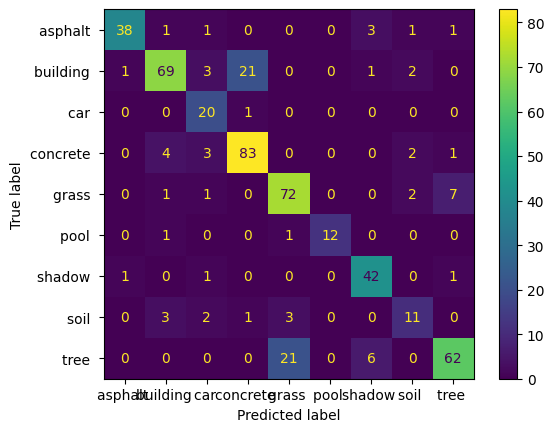

In [51]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: compute the predictions on the test set
predictions_test = rfc.predict(data_test) 

# Step 2: display the confusion matrix on the test set
cm = confusion_matrix(target_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot() 

# Step 3: compute the accuracy on the test set
accuracy = rfc.score(data_test, target_test)
print('Accuracy: ',round(accuracy,2))


Comment: The biggest mistake happen between tree and grass, where 21 samples were classificad as grass when they are trees. Also, trees which are classified as shadows are 6. Concrete and building have also 4 samples as building which are actually concrete. The biggest errors are not that relevant because they are same type somehow, pretty similar. 

Number of misclassified observations in the test set:50

**Question 3. We will now focus on the calibration of some RF parameters: `n_estimators` and `max_features`. To calibrate these parameters, we will used the OOB errors. The code below shows how the OOB error can be measured at the addition of each new tree during training. The resulting plot can be used to approximate a suitable value of `n_estimators` at which the OOB error stabilizes. Comment this plot. What value for `n_estimators` does it seem suitable ?**

*Indication: a suitable value for `n_estimators` is a value for which the oob error of the forest is stable.*

N_ESTIMATORS ARE THE NUMBER OF TREES! IMP. We need a large n_estimator because it makes the model stable


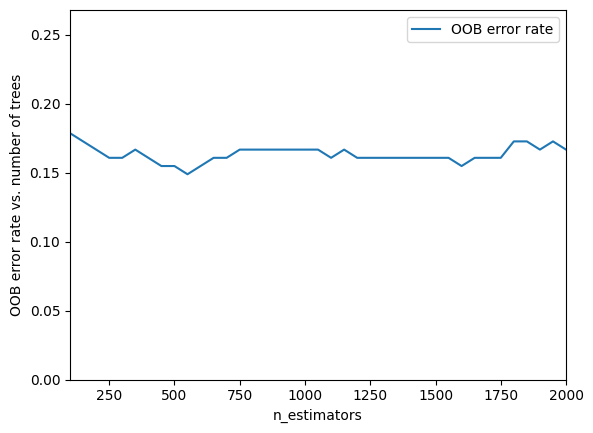

In [41]:
RANDOM_STATE = 0


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=50

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i, max_features=max_features,random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 1.5*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()


Comment of the plot and choice of a suitable value for `n_estimators`: between 750 and 1250. 750 will be faster, less complicate






**Question 4. Now, we will repeat `B` times a `k`-fold cross validation with the function GridSearchCV to calibrate the parameter `max_features`. Complete the command below, comment the results and select suitable value for `max_features`. For `n_estimators`use the value previously selected.**

**Indications:**
- **Consider the following values`max_features = (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9)`. The values (0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9) for `max_features` represent the proportions of selected features. See the documention of [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) class.**
- **we will repeat `B=10`times a k-fold crossvalidation with `k=3`.**

In [52]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: create a grid with all the values that we will considers for the two paramters
grid = {
    'max_features':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

# Step 2: use the grid to to search for the best couple of parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
rf = RandomForestClassifier(n_estimators=750, random_state=0,n_jobs=-1) # create the forest model to tune

B=10
cv_split = RepeatedKFold(n_splits=3, n_repeats=B, random_state=0)
rf_cv = GridSearchCV(estimator=rf,param_grid=grid, cv=cv_split,n_jobs=-1)
rf_cv.fit(data, target) # Fit the CV search

# Step 3: get the best parameters (with the higher performance)
print(rf_cv.cv_results_)

{'mean_fit_time': array([0.81378582, 0.98752095, 1.1701696 , 1.43899633, 1.65922156,
       1.88217713, 2.10853061, 2.34440223, 2.4884158 ]), 'std_fit_time': array([0.13601828, 0.1625926 , 0.12705989, 0.12066185, 0.12353392,
       0.13381176, 0.1344545 , 0.12485581, 0.28535028]), 'mean_score_time': array([0.07235297, 0.09695587, 0.09251647, 0.09232646, 0.09036327,
       0.08613419, 0.08485665, 0.08052541, 0.08139687]), 'std_score_time': array([0.01691326, 0.02811031, 0.01889139, 0.00922181, 0.02671956,
       0.00888993, 0.00885818, 0.00758821, 0.0158237 ]), 'param_max_features': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=1e+20), 'params': [{'max_features': 0.1}, {'max_features': 0.2}, {'max_features': 0.3}, {'max_features': 0.4}, {'max_features': 0.5}, {'max_features': 0.6}, {'max_features': 0.7}, {'max_features': 0.8}, {'max_features': 0.9}],

If we use the best_params_ then the algorithm is choosing if you have multiples with the same score. So looking at the results and just taking into account 2 decimals, the mean_test_score are pretty similar between 0.83 and 0.84, also looking at the standard test score is similar. I took the smaller, which also means the faster model, the default one.

In [ ]:
#this is worth it when there are different results, when the cores change a lot between them.
print(rf_cv.best_params_)
print(rf_cv.best_score_)


{'max_features': 0.4}
0.8172619047619047


Result interpretation and choice of tuned value for  `max_features`: default

**Question 5. Now, replace the value of `max_features`by the one that you selected at the previsous question and check again the optimal value of `n_estimators` when using the optimal value for `max_features`. Comment your result. What value for `n_estimators`do you finally choose ?**

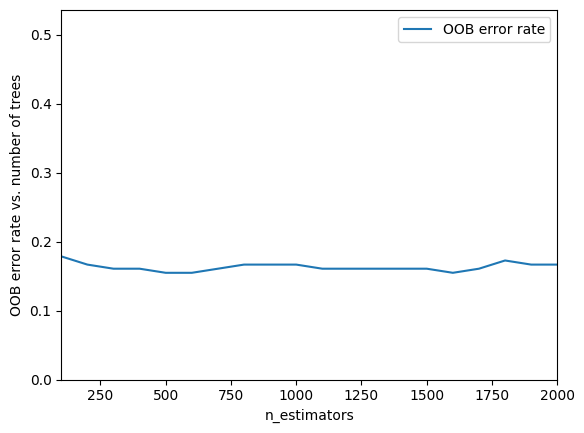

In [55]:
##------- Complete the command below by filling in the gaps '...'.-------##
RANDOM_STATE = 0 # Note: if you modifiy the random stat, the results can be sligthly different


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = []

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
step=100

for i in range(min_estimators, max_estimators+1, step):
    rf = RandomForestClassifier(warm_start=True, n_estimators=i,random_state=RANDOM_STATE, oob_score=True)
    rf.fit(data, target)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - rf.oob_score_
    error_rate.append(oob_error)
  

# Plot Generate the "OOB error rate" vs. "n_estimators" plot

plt.plot(range(min_estimators, max_estimators +1, step), error_rate, label="OOB error rate")

plt.ylim(0, 3*max(error_rate)) 
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate vs. number of trees")
plt.legend(loc="upper right")
plt.show()

We continue with 750 but it is possible also use 100 then the model will be simpler.

**Question 6. Build the random forest `opt_rfc` by using the best values for the parameters `n_estimators` and `max_features`. Compute the accuracy on the test set and display the confusion matrix.** 

Accuracy in opt_rfc:  0.81


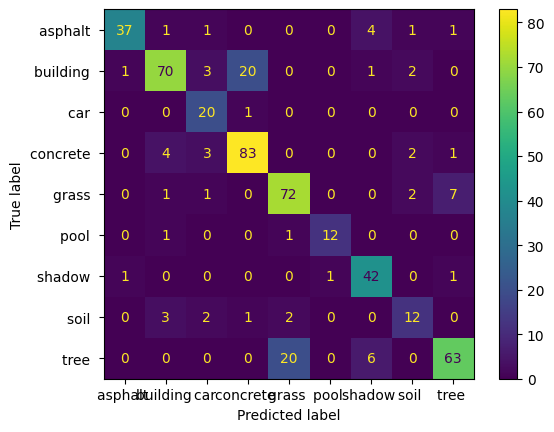

In [54]:
##------- Complete the command below by filling in the gaps '...'.-------##

# Step 1: fit a random forest with the best values for parameters
opt_rfc = RandomForestClassifier(n_estimators=750,oob_score=True,random_state=0)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
opt_rfc.fit(data, target)

# Step 3: compute the accuracy and the confusion matrix
predictions_test_2 = opt_rfc.predict(data_test) 
cm_2 = confusion_matrix(target_test, predictions_test_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2,display_labels=opt_rfc.classes_)
disp.plot() 

# Step 4: compute the accuracy
accuracy_2 = opt_rfc.score(data_test, target_test)
print('Accuracy in opt_rfc: ',round(accuracy_2,2))

The calibration give us the same results, because the data is too clean.

**Question 7. what value for`max_features` we have to choose if we want to apply the bagging algorithm with CART instead of a random forest ? Build this model and compute the prediction error of this model based on the test set. We will call this model $bag$.**

**Indication: use the value selected previously for the parameter `n_estimators`.** 

How bagging use all the features, in the random forest variable we change that. Random forest take a porcion of the features and bagging take all of them.

0.8


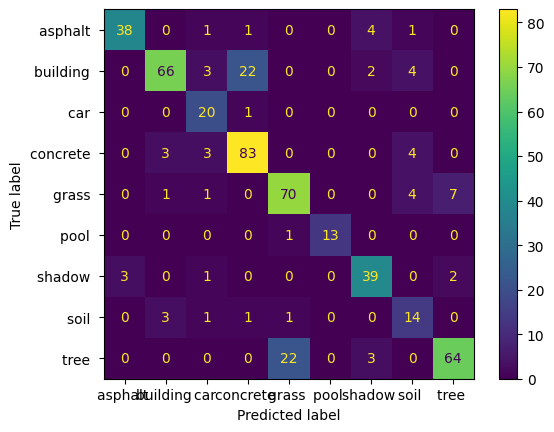

In [56]:
##------- Complete the command below by filling in the gaps '...'.-------##
from sklearn.ensemble import BaggingClassifier

# Step 1: fit a a bagging model (changing the max_features to the number of all features)
bag = RandomForestClassifier(n_estimators=750, max_features=147,oob_score=True,random_state=0,bootstrap=True)


# Step 2: build the random forest on the train set by indicating the input data and the target variable 
bag.fit(data, target)

# Step 3: compute the prediction on the test set and the confusion matrix
predictions_test_bag = bag.predict(data_test) 
cm_bag = confusion_matrix(target_test, predictions_test_bag)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bag,display_labels=bag.classes_)
disp.plot() 

# Step 4: compute the accuracy on the test set
accuracy_bag = bag.score(data_test, target_test)
print(round(accuracy_bag,2))



**Question 8. Fit a maximal CART tree on the training set using the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class, like in the first lab session. Next, compute the prediction error of this tree based on the test set. Name this tree `single_tree`.**

**Indication: to get the maximal tree, use `max_depth=None` (the default value).**

0.72


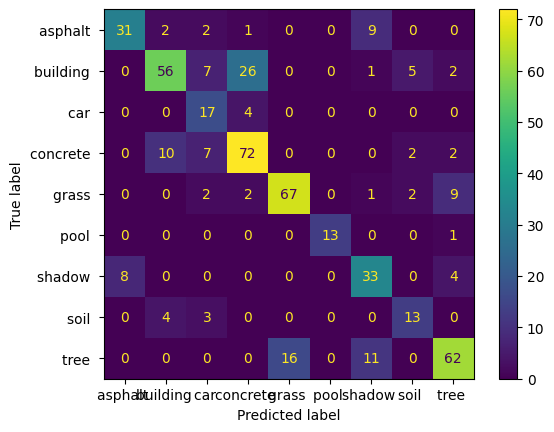

In [61]:
## Your code
from sklearn.tree import DecisionTreeClassifier

single_tree = DecisionTreeClassifier(max_depth=None, random_state=0)
single_tree.fit(data, target)

predictions_test_single_tree = single_tree.predict(data_test)

cm_single_tree = confusion_matrix(target_test, predictions_test_single_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_single_tree,display_labels=single_tree.classes_)
disp.plot() 

accuracy_single_tree = single_tree.score(data_test, target_test)
print(round(accuracy_single_tree,2))


**Question 9. Compare your three models `opt_rfc`, `bag`and `single_tree` using suitable performance criteria. What model do you choose and why ?**

Your Answer: using the accuracy criteria, the best is random forest with 81%, then bagging with 80% and finally the single tree with 72%. Also, `opt_rfc` slightly outperforms `bag`. These two models have good performances and for these two models, building can be predicted as concret and tree can be predicted as grass (or conversely). The single tree has smaller predictive performance than the two other models. In the single tree, building can be predicted as concret or car, tree can be predicted as grass or shadow and grass can be predicted as tree. 

We choose `opt_rfc` because it has the best predictive performance.



**Question 10. The MDA of each of the 147 features in the dataset has been independently computed `n__repeats` times on the test set (using each time another permutation of each feature). The code below shows the boxplot of the mean decrease in accuracy (MDA) for the 15 features with the highest average MDA.Comment the plot.** 

/var/folders/60/bl70l_4s1976pvm1vdp3wz280000gn/T/ipykernel_12241/2976801541.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[invert_sorted_idx].T,


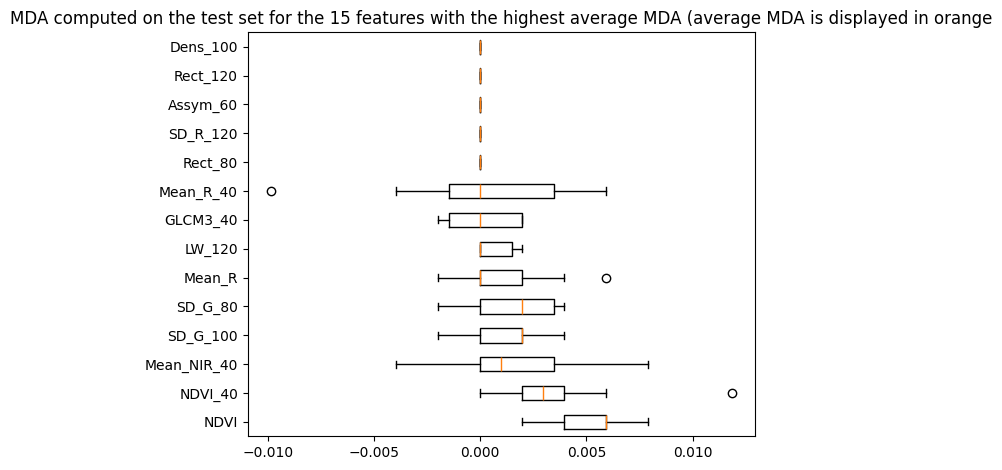

In [60]:
## Computation of the MDA for all features
from sklearn.inspection import permutation_importance
result = permutation_importance(opt_rfc, data_test, target_test, n_repeats=10, random_state=0, n_jobs=2)


## Plot of the MDA for the 15 features with the highest average MDA
sorted_idx = result.importances_mean.argsort()
invert_sorted_idx=sorted_idx[::-1][:14]# keep only the 15 features with the highest average MDA
fig, ax = plt.subplots()
ax.boxplot(result.importances[invert_sorted_idx].T,
           vert=False, labels=data_test.columns[invert_sorted_idx])
ax.set_title("MDA computed on the test set for the 15 features with the highest average MDA (average MDA is displayed in orange")
fig.tight_layout()
plt.show()

Solution for the comments about the plot: Then MDA is the orange line(mean) in each box. As bigger the Mean Decrease in Acurracy, more important the variable/feature. Seems like the more important one is the NDVI. each box is the variability of MDA in the 10 permutations.

**Question 11. What importance index is stored in `opt_rfc.feature_importances_` ? Use the Python documentation [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to answer.** Comments about the plot above: .......

Answer: this is an array of length equal to the number of input features. Each value is a normalized importance score of the corresponding feature. Example, an score of 0.7 has 70 percentage of influence in the error of the model. However, this is no recommended to use it because in the literature is not well justify mathematically.

**Question 12. The code below plot the 30 features with the highest values in `feature_importances_` . Comment the plot and compare with the boxplots in Question 10.** 

<BarContainer object of 15 artists>

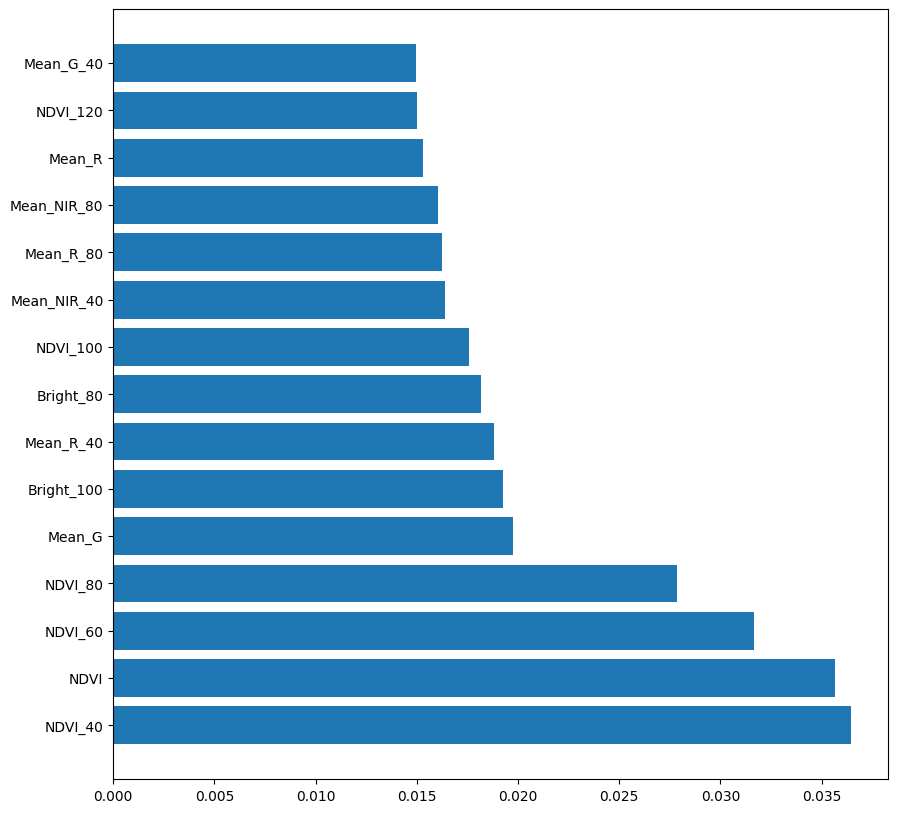

In [62]:
sorted_idx2 = opt_rfc.feature_importances_.argsort()
invert_sorted_idx2=sorted_idx2[::-1][:15]# keep only the 15 features with the highest average MDA
fig = plt.figure(figsize=(10,10))
plt.barh(data.columns[invert_sorted_idx2], opt_rfc.feature_importances_[invert_sorted_idx2])

Answer: This result shows again that the most important variable is NDVI. 


## Ex 2: discover several variable selection methods

Here, we keep working with the urban dataset.

**Questions:**
 - 1) **Based on the end of the exercice select a subset of variable and build a new random forest based only the selected subset of features. Justify your choice.**
 - 2) **Apply the function `RFE` from `sklearn.feature_selection` that implement the RFE algorithm and select the best size of subset. Use MDA for the importance measure. Build a new random forest based on the selected subset.**
 - 3) **Apply now the boruta algorithm using the function `BorutaPy`from `boruta`. Don't select a size for the subest of selected features, the size will be determined automatically by the function. Then, build a random forest based on the selected subset.**
 - 4) **Compare all models. What model do you select and why?**
 
 
**Justify all your choices.**

Accuracy:  0.76


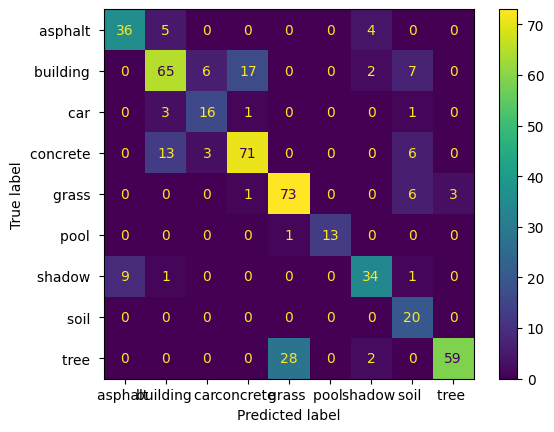

In [66]:
##---- Write your answer ----##

selected_colums = ['NDVI','NDVI_40','NDVI_60', 'NDVI_80','Mean_G','Bright_100']

data, target = ulc_train[selected_colums], ulc_train[target_column]
data_test, target_test = ulc_test[selected_colums], ulc_test[target_column]

# Step 1: create the object rfc, it is a RandomForestClassifier object with n_estimators=500, max_features='auto' and random_state=0
rfc = RandomForestClassifier(n_estimators=750,random_state=0, oob_score=True)

# Step 2: build the random forest on the train set by indicating the input data and the target variable 
#
rfc.fit(data, target)

# Step 1: compute the predictions on the test set
predictions_test = rfc.predict(data_test) 

# Step 2: display the confusion matrix on the test set
cm = confusion_matrix(target_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot() 

# Step 3: compute the accuracy on the test set
accuracy = rfc.score(data_test, target_test)
print('Accuracy: ',round(accuracy,2))



### Q2

Recursive Feature Elimination(RFE) is a feature selection algorithm.
RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.
This is achieved by at first fitting the model using all the features in a given set, ranking features by importance, then discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.

In [14]:
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

cv_method = KFold(n_splits=3) # 3 folds as in the example

rf = RandomForestClassifier(n_estimators=750,oob_score=True,random_state=0)
rfecv = RFECV(
    PermutationImportance(rf,  scoring='accuracy', n_iter=1, random_state=0, cv=2 ),
    cv=cv_method,
    scoring='accuracy',
    step=0.1
)

In [15]:
rfecv.fit(data.values, target.values)

,estimator,PermutationIm...ng='accuracy')
,step,0.1
,min_features_to_select,1
,cv,KFold(n_split...shuffle=False)
,scoring,'accuracy'
,verbose,0
,n_jobs,None
,importance_getter,'auto'
,n_estimators,750
,criterion,'gini'
,max_depth,None


In [16]:
rfecv.ranking_

array([6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 3, 1, 3, 3, 4, 4, 1, 1, 3, 1, 4, 1, 5, 1, 5, 5, 5, 1,
       4, 4, 5, 5, 4, 3, 3, 3, 3, 5, 5, 3, 1, 3, 2, 2, 1, 2, 4, 1, 2, 1,
       2, 1, 3, 2, 4, 1, 6, 7, 3, 6, 3, 6, 7, 4, 7, 6, 6, 7, 7, 7, 6, 2,
       7, 2, 2, 1, 7, 7, 6, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 1, 6, 2, 1, 1,
       2, 1, 1, 1, 2, 2, 1, 5, 5, 5, 1, 5, 1, 1, 5, 5, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 1, 1, 4])

In [19]:
subset2 = [f for f,s in zip(data.columns, rfecv.support_) if s]
print(subset2)

['Round', 'Bright', 'Compact', 'ShpIndx', 'Mean_G', 'Mean_R', 'Mean_NIR', 'SD_G', 'SD_R', 'SD_NIR', 'LW', 'GLCM1', 'Rect', 'GLCM2', 'Dens', 'Assym', 'NDVI', 'BordLngth', 'GLCM3', 'BrdIndx_40', 'Round_40', 'Bright_40', 'Compact_40', 'Mean_G_40', 'SD_NIR_40', 'LW_40', 'Rect_40', 'Dens_40', 'NDVI_40', 'Area_60', 'Rect_60', 'NDVI_60', 'BrdIndx_80', 'Round_80', 'Compact_80', 'Mean_NIR_80', 'Mean_R_100', 'BrdIndx_120', 'Bright_120', 'Compact_120', 'Mean_G_120', 'Mean_R_120', 'Mean_NIR_120', 'SD_NIR_120', 'GLCM2_120', 'Assym_120', 'NDVI_120', 'BrdIndx_140', 'Area_140', 'Bright_140', 'Compact_140', 'ShpIndx_140', 'Mean_G_140', 'Mean_R_140', 'Mean_NIR_140', 'SD_G_140', 'SD_R_140', 'SD_NIR_140', 'GLCM2_140', 'Dens_140', 'Assym_140', 'NDVI_140', 'BordLngth_140']


Accuracy of rf1: 0.82


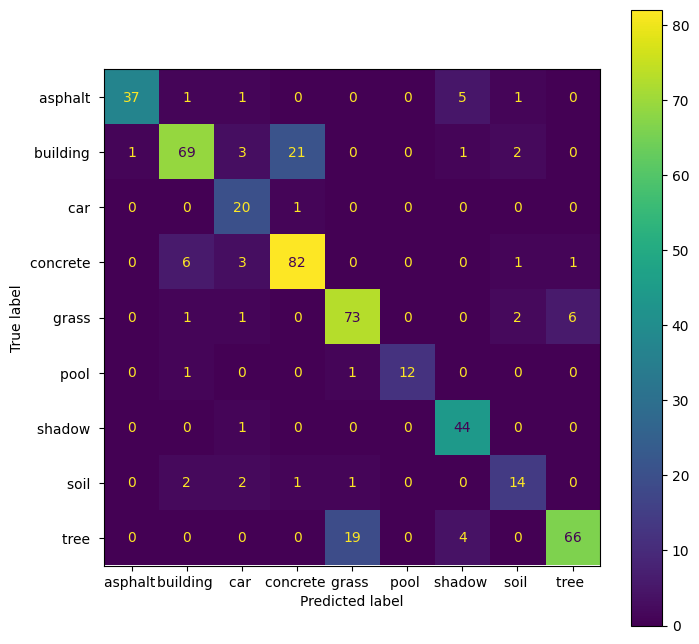

In [22]:
rf2 = RandomForestClassifier(n_estimators=750,oob_score=True,random_state=0)

rf2.fit(data[subset2], target)


pred2 = rf2.predict(data_test[subset2]) 
cm2 = confusion_matrix(target_test, pred2)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=rf2.classes_)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=rf2.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp1.plot(ax=ax)  

# Step 4: compute the accuracy on the test set
acc2 = rf2.score(data_test[subset2],target_test)
print("Accuracy of rf1:", round(acc2,2))

Here we use RFE

In [24]:
from sklearn.feature_selection import RFE

rf = RandomForestClassifier(n_estimators=750,oob_score=True,random_state=0)
rfe = RFE(rf,step=0.1)
rfe.fit(data, target)

subset3 = [f for f,s in zip(data.columns, rfe.support_) if s]
print(subset3)
print(len(subset3))

['BrdIndx', 'Area', 'Bright', 'Compact', 'Mean_G', 'Mean_R', 'Mean_NIR', 'SD_G', 'SD_R', 'SD_NIR', 'NDVI', 'BordLngth', 'GLCM3', 'BrdIndx_40', 'Area_40', 'Bright_40', 'Mean_G_40', 'Mean_R_40', 'Mean_NIR_40', 'SD_G_40', 'SD_R_40', 'NDVI_40', 'BordLngth_40', 'BrdIndx_60', 'Area_60', 'Bright_60', 'ShpIndx_60', 'Mean_G_60', 'Mean_R_60', 'Mean_NIR_60', 'SD_G_60', 'NDVI_60', 'BordLngth_60', 'BrdIndx_80', 'Area_80', 'Bright_80', 'ShpIndx_80', 'Mean_G_80', 'Mean_R_80', 'Mean_NIR_80', 'SD_G_80', 'SD_R_80', 'SD_NIR_80', 'NDVI_80', 'BordLngth_80', 'BrdIndx_100', 'Bright_100', 'ShpIndx_100', 'Mean_G_100', 'Mean_R_100', 'Mean_NIR_100', 'SD_G_100', 'SD_R_100', 'SD_NIR_100', 'NDVI_100', 'BordLngth_100', 'BrdIndx_120', 'Bright_120', 'ShpIndx_120', 'Mean_G_120', 'Mean_R_120', 'Mean_NIR_120', 'NDVI_120', 'BordLngth_120', 'BrdIndx_140', 'Bright_140', 'ShpIndx_140', 'Mean_G_140', 'Mean_R_140', 'Mean_NIR_140', 'SD_G_140', 'NDVI_140', 'BordLngth_140']
73
